<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 10: Vectores autorregresivos (VAR)</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Estimación de un VAR de la política monetaria de Costa Rica</div> 
</center>
<i>Creado:     2020-Jun-15 
    <br>
    Actualizado: 2020-Oct-25</i>

# Pasos previos

## Cargar paquetes

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Este cuaderno está corriendo en Google Colab. Es necesario instalar el paquete bccr para obtener los datos")
    !pip install bccr
else:
    print("Este cuaderno está corriendo localmente.")


Este cuaderno está corriendo localmente.


In [2]:
from bccr import ServicioWeb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from statsmodels.tsa.api import VAR
import statsmodels.api as sm

In [3]:
plt.rcParams
plt.rc('font', serif=['Computer Modern'])

## Descargar datos

In [4]:
consulta = ServicioWeb()

In [5]:
consulta.buscar(frase='desempleo abierto')

,DESCRIPCION,descripcion,Unidad,Medida,periodo
codigo,,,,,
917,Node('/BCCR/Demográficas y Mercado Laboral/Tasa de desempleo abierto [917]'),Tasa de desempleo abierto,Porcentaje,Unidades,Anual
21785,Node('/BCCR/Demográficas y Mercado Laboral/Tasa de desempleo abierto [21785]'),Tasa de desempleo abierto,Porcentaje,Unidades,Anual
22796,Node('/BCCR/Demográficas y Mercado Laboral/Tasa de desempleo abierto [22796]'),Tasa de desempleo abierto,Porcentaje,Unidades,Trimestral


In [6]:
u = consulta({'22796':'u', '3541':'R'}, FechaInicio='2010-07-01', func=np.mean)

In [7]:
inf = consulta({'25482':'$\pi$'}, FechaInicio='2004/07/01').pct_change(12).resample('Q').mean().dropna()*100

In [8]:
datos = pd.concat([u, inf], axis=1).dropna()

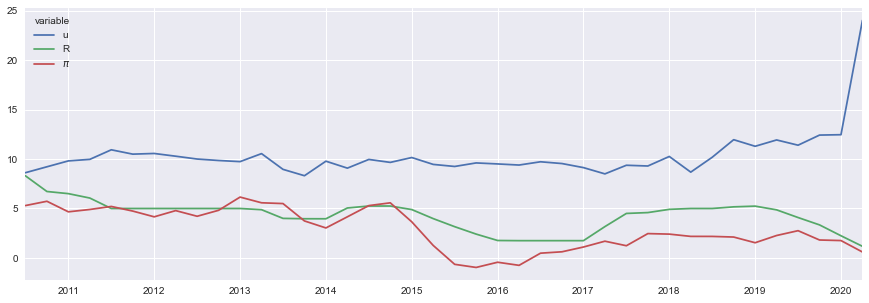

In [9]:
datos.plot(figsize=[15,5])

**Importante** Por fines didácticos, ahora restringimos la muestra a datos hasta el primer trimestre de 2020. El gran aumento en la tasa de desempleo que siguió al impacto de la pandemia del COVID no se ve reflejado en las otras variables del modelo. Como ejercicio, estime y analice este mismo VAR con datos hasta el segundo trimestre del 2020 (cambiando la siguiente celda); verá que en ese caso el VAR estimado resulta inestable!!

In [10]:
datos = datos[:'2020Q1'][['u', '$\pi$', 'R']]

## Graficar los datos utilizados

[Text(0, 0.5, 'puntos porcentuales'),
 Text(0.5, 1.0, 'Desempleo, inflación y tasa de política monetaria')]

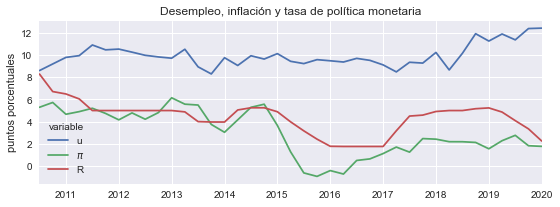

In [11]:
fig, ax = plt.subplots(figsize=[9,3])
datos.plot(ax=ax)
ax.set(title='Desempleo, inflación y tasa de política monetaria', ylabel='puntos porcentuales')
#fig.savefig('VAR-variables.pdf', bbox_inches='tight')

# Estimar un VAR

In [12]:
model = VAR(datos)
res = model.fit(4, ic='bic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Oct, 2020
Time:                     18:46:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.30856
Nobs:                     38.0000    HQIC:                  -1.64170
Log likelihood:          -115.071    FPE:                   0.161485
AIC:                     -1.82569    Det(Omega_mle):        0.119601
--------------------------------------------------------------------
Results for equation u
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.305139         1.265376            1.822           0.069
L1.u             0.708084         0.125437            5.645           0.000
L1.$\pi$        -0.127880         0.087455           -1.462           0.144
L1.R    

**Autocorrelograma de los residuos**

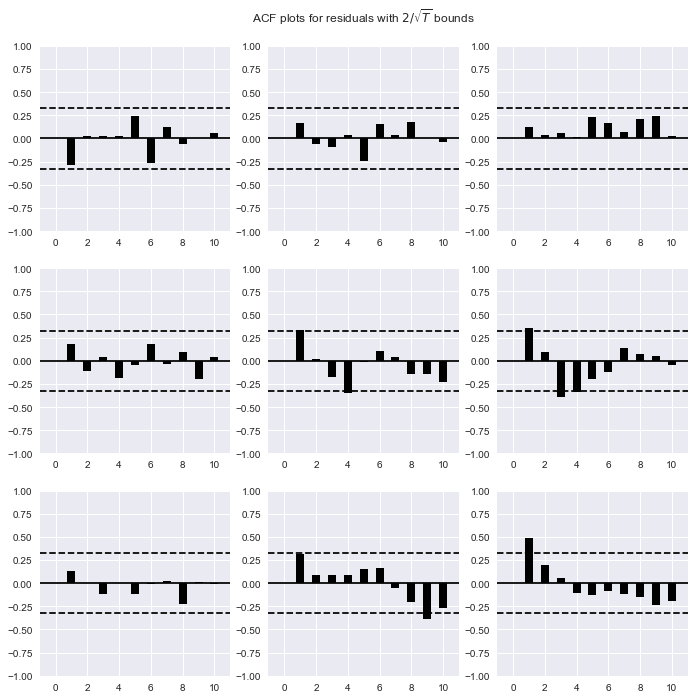

In [13]:
res.plot_acorr();

## Número óptimo de rezagos para el VAR 

In [14]:
temp = model.select_order(4).summary()
temp

,AIC,BIC,FPE,HQIC
0,1.227,1.360,3.411,1.273
1,-1.779,-1.246*,0.1693,-1.595
2,-2.121*,-1.188,0.1219*,-1.799*
3,-2.007,-0.6741,0.1411,-1.547
4,-2.002,-0.2689,0.1511,-1.404


Exportar esta tabla a LaTeX

In [15]:
with open('VAR-ic.tex','w') as archivo:
    archivo.write(temp.as_latex_tabular())

## Pronosticar las variables

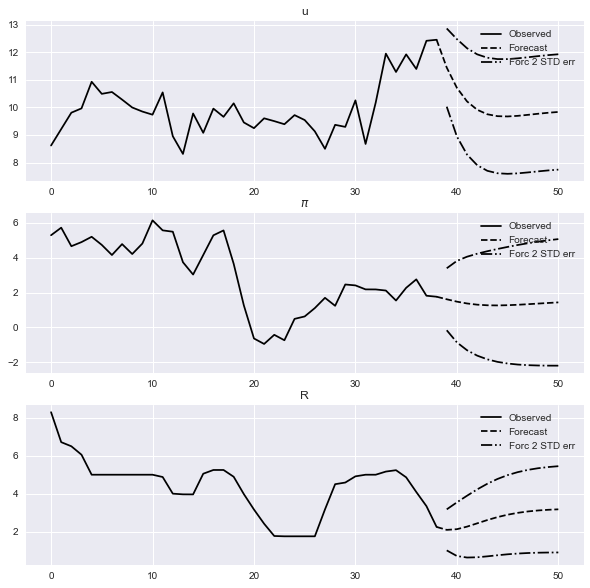

In [16]:
fig = res.plot_forecast(12);
#fig.savefig('VAR-forecast.pdf', bbox_inches='tight')

## Analizar las funciones de impulso respuesta

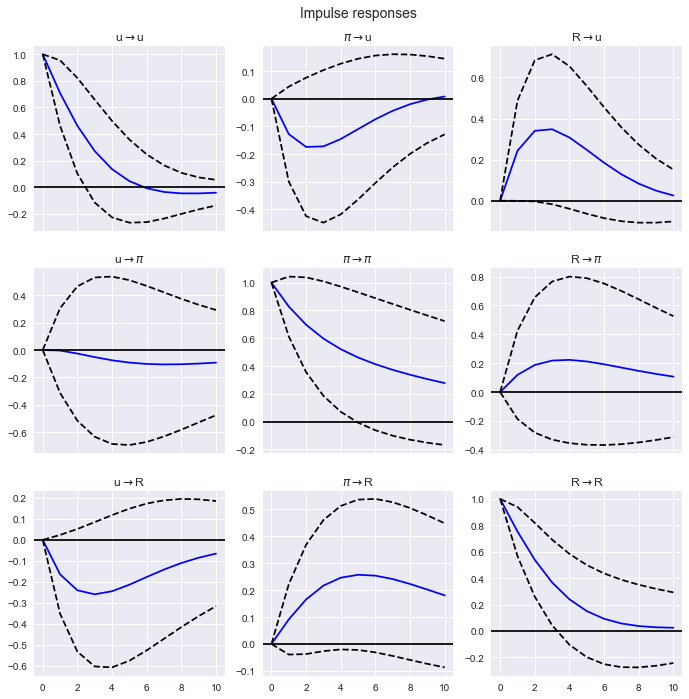

In [17]:
fig = res.irf(10).plot(subplot_params={'figsize':[12,4]});
#fig.savefig('VAR-irf-1.pdf', bbox_inches='tight')

## Analizar la descomposición de varianza

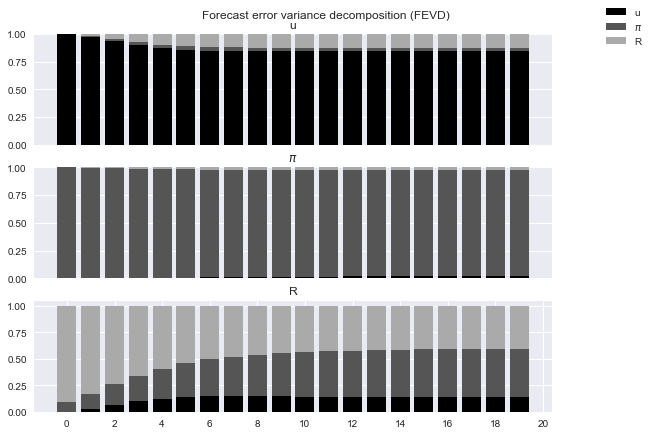

In [18]:
fig=res.fevd(20).plot(figsize=[9,6]);
fig.axes[0].set(xticks=[])
fig.axes[1].set(xticks=[])
fig.axes[2].set(xticks=np.arange(0,21,2))
for ax in fig.axes:
    ax.set(yticks=[0,0.25,0.5,0.75,1.0])
    
#fig.savefig('VAR-fevd.pdf', bbox_inches='tight')    

## Estudiar la causalidad de Granger

In [19]:
granger = pd.DataFrame(np.zeros([3,3]), index = datos.columns.values, columns=datos.columns.values)

for i in datos.columns:
    for j in datos.columns:
        temp = res.test_causality(i, j)
        print(temp.summary())
        granger.loc[j, i] = np.round(temp.pvalue,3)

Granger causality F-test. H_0: u does not Granger-cause u. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         31.87          3.934   0.000 (1, 102)
----------------------------------------------
Granger causality F-test. H_0: $\pi$ does not Granger-cause u. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.138          3.934   0.147 (1, 102)
----------------------------------------------
Granger causality F-test. H_0: R does not Granger-cause u. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.831          3.934   0.053 (1, 102)
----------------------------------------------
Granger causality F-test. H_0: u does not Granger-cause $\pi$. Conclusion: fail to reject H_

In [20]:
granger.index.name = 'Explicativa'
granger.columns.name = 'Dependiente'
granger

Dependiente,u,$\pi$,R
Explicativa,,,
u,0.000,0.980,0.089
$\pi$,0.147,0.000,0.173
R,0.053,0.446,0.000


In [21]:
granger.to_latex('VAR-Granger-causality.tex', escape=False)

## ¿Qué tan sensibles son los resultados al ordenamiento de las variables? Estimando todas las combinaciones 

In [22]:
from itertools import permutations

In [23]:
ordenamientos = [x for x in permutations(datos.columns)]

In [24]:
def chol_irf(orden, h=10):
    res = VAR(datos[[*orden]]).fit(1)
    irf = res.irf(h).orth_irfs.flatten()
    idx = pd.MultiIndex.from_product([np.arange(h+1),orden, orden])
    return pd.DataFrame({'→'.join(orden): irf}, index=idx)

In [25]:
irfs = pd.concat([chol_irf(A) for A in ordenamientos], axis=1)

In [26]:
irfs = irfs.stack().unstack(level=[2,1,3])

In [27]:
irfs

$\pi$                                                           R                                ...                                                 u                                                  
       $\pi$                                                       $\pi$                                ...         u                                       u                                                  
   u→$\pi$→R u→R→$\pi$ $\pi$→u→R $\pi$→R→u R→u→$\pi$ R→$\pi$→u u→$\pi$→R u→R→$\pi$ $\pi$→u→R $\pi$→R→u  ... $\pi$→u→R $\pi$→R→u R→u→$\pi$ R→$\pi$→u u→$\pi$→R u→R→$\pi$ $\pi$→u→R $\pi$→R→u R→u→$\pi$ R→$\pi$→u
0   0.908887  0.864903  0.909335  0.909335  0.864903  0.865344  0.000000  0.279316  0.000000  0.000000  ...  0.000000  0.004781 -0.002436 -0.002436  0.724194  0.724194  0.723837  0.723821  0.724189  0.723821
1   0.772725  0.716075  0.773183  0.773183  0.716075  0.716531  0.062658  0.297097  0.062658  0.062641  ...  0.127776  0.131165  0.096819  0.096819  0.515989  0.515989  0.513381  0.512526  0.516317  0.512526
2   0.665204  0.602717  0.666094  0.666094  0.602717  0.603616  0.098582  0.298240  0.098582  0.098462  ...  0.178733  0.180946  0.138025  0.138025  0.338887  0.338887  0.335561  0.334373  0.339353  0.334373
3   0.579973  0.516668  0.581410  0.581410  0.516668  0.518126  0.114665  0.287351  0.114665  0.114420  ...  0.182773  0.184077  0.143289  0.143289  0.201204  0.201204  0.198044  0.196832  0.201687  0.196832
4   0.511505  0.450729  0.513433  0.513433  0.450729  0.452686  0.117217  0.268739  0.117217  0.116862  ...  0.161661  0.162316  0.128881  0.128881  0.102158  0.102158  0.099593  0.098523  0.102592  0.098523
5   0.455349  0.399074  0.457633  0.457633  0.399074  0.401394  0.111413  0.245957  0.111413  0.110977  ...  0.130070  0.130295  0.105893  0.105893  0.036303  0.036303  0.034470  0.033610  0.036659  0.033610
6   0.408132  0.357298  0.410620  0.410620  0.357298  0.359825  0.101145  0.221676  0.101145  0.100662  ...  0.097051  0.097018  0.081267  0.081267 -0.003536 -0.003536 -0.004668 -0.005309 -0.003263 -0.005309
7   0.367427  0.322259  0.369980  0.369980  0.322259  0.324852  0.089119  0.197723  0.089119  0.088619  ...  0.067532  0.067365  0.058862  0.058862 -0.024506 -0.024506 -0.025054 -0.025500 -0.024308 -0.025500
8   0.331565  0.291838  0.334071  0.334071  0.291838  0.294384  0.077061  0.175227  0.077061  0.076566  ...  0.043645  0.043427  0.040425  0.040425 -0.032811 -0.032811 -0.032919 -0.033207 -0.032675 -0.033207
9   0.299444  0.264686  0.301825  0.301825  0.264686  0.267105  0.065946  0.154779  0.065946  0.065475  ...  0.025776  0.025556  0.026363  0.026363 -0.033352 -0.033352 -0.033159 -0.033329 -0.033263 -0.033329
10  0.270359  0.239996  0.272568  0.272568  0.239996  0.242239  0.056229  0.136594  0.056229  0.055791  ...  0.013349  0.013155  0.016333  0.016333 -0.029709 -0.029709 -0.029334 -0.029421 -0.029654 -0.029421

[11 rows x 54 columns]

Text(0.5, 0.98, 'Impulso respuesta, todos los posibles ordenamientos de Choleski')

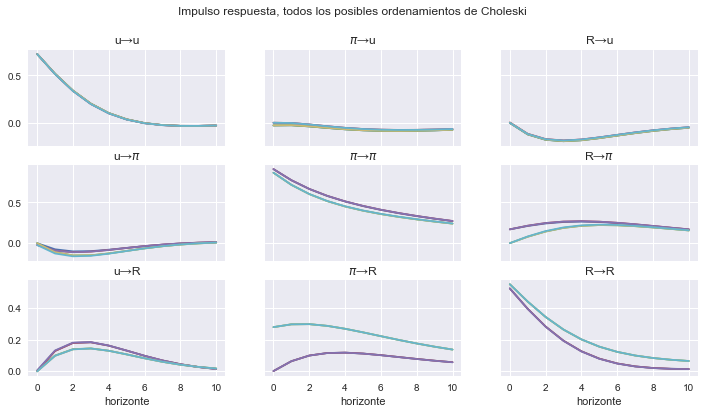

In [28]:
fig, axs = plt.subplots(3,3, figsize=[12,6], sharex=True, sharey='row')

for i, impulso in enumerate(datos.columns):
    for j, respuesta in enumerate(datos.columns):
        irfs[impulso][respuesta].plot(ax=axs[i,j], legend=False)
        axs[j,i].set_title(impulso + '→' + respuesta )

for ax in axs[-1]:
    ax.set_xlabel('horizonte')
        
fig.suptitle('Impulso respuesta, todos los posibles ordenamientos de Choleski')   
#fig.savefig('VAR-irf-all-orderings.pdf', bbox_inches='tight')